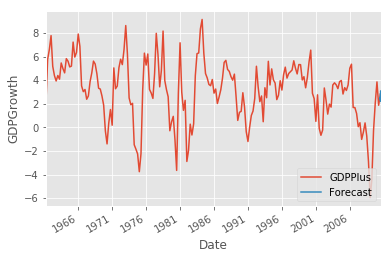

In [21]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import style
import math
import datetime
style.use('ggplot')

def GDPPlus():
    df = quandl.get('FRBP/GDPPLUS', authtoken='your token')
    df.rename(columns={'Value':'GDPPlus'}, inplace=True)
    return df

def unemployment_rate():
    #read_excel has many more option ex : droping row, stating from designated row, and so on
    df = pd.read_excel('unemployment.xlsx')
    # keep year as index, stack other columns 'against' it
    stacked = df.set_index('Year').stack()
    # set the name of the new series created
    df = stacked.reset_index(name='month')
    # drop the 'source' level (month.*)
    df.drop('level_1', axis=1, inplace=True)

    datedf = pd.date_range(start = '1947-12-31', periods = 836, freq = 'M')
    df = df.set_index(pd.DatetimeIndex(datedf))
    df = df.resample('3M').mean().shift(1)
    df.dropna(inplace=True)
    df.drop('Year', axis=1, inplace=True)
    return df

def M2():
    df = pd.read_csv('FRB_H6.csv', header = 5, index_col =0, parse_dates=True)
    df = df['M2.M']
    # for now m1.m column is regarded as a series. Series does not gave 'infro' function
    df = pd.DataFrame(df)
    df.rename(columns={'M2.M' : 'M2_pch_change'}, inplace=True)
    df = df.pct_change()
    df = df.resample('Q').mean()
    return df

df = pd.concat([GDPPlus(), unemployment_rate(), M2()], axis=1)
df.rename(columns={'month' : 'unemployment_rate'}, inplace = True)
df.dropna(inplace = True)


forcast_col = 'GDPPlus'

forcast_out = int(math.ceil(0.1*len(df)))
df['label'] = df[forcast_col].shift(-forcast_out)
df.dropna(inplace=True)



x = np.array(df.drop(['label'], 1))
x = preprocessing.scale(x)
y = np.array(df['label'])


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#clf = svm.SVR()
clf = LinearRegression()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)

x = x[:-forcast_out]
x_lately = x[-forcast_out:]
forecast_set = clf.predict(x_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['GDPPlus'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('GDPGrowth')
plt.show()
